In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Classification using SMOTE Over Sampling Method
# Before SMOTE = Accuracy: 0.9996, Precision: 0.9603, F1: 0.8897, AUC: 0.9780
#         [Recall: 0.8288]
# After SMOTE = Accuracy: 0.9996, Precision: 0.9118, F1: 0.8794, AUC: 0.9814
#         [Recall: 0.8493]

In [3]:
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE # SMOTE Over Sampling / "imblearn" means "Imbalanced Learn"

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df_v0 = pd.read_csv("creditcard.csv")
df_v0.shape

(284807, 31)

In [9]:
df_v0.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


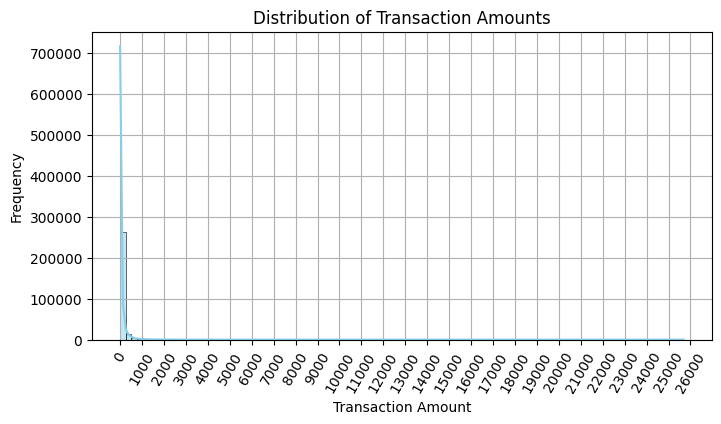

In [19]:
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(df_v0['Amount'], bins=100, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

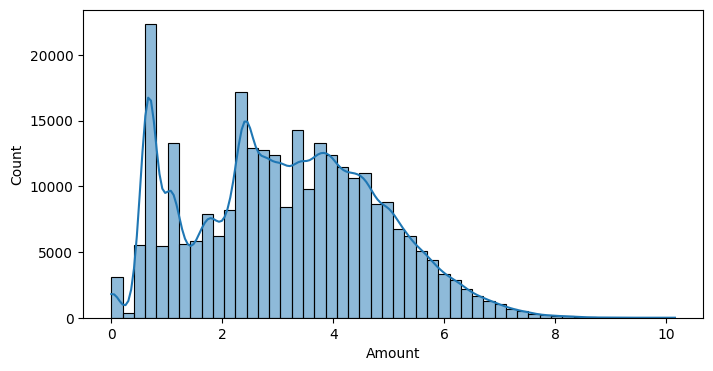

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(df_v0['Amount']), bins=50, kde=True)
plt.show()

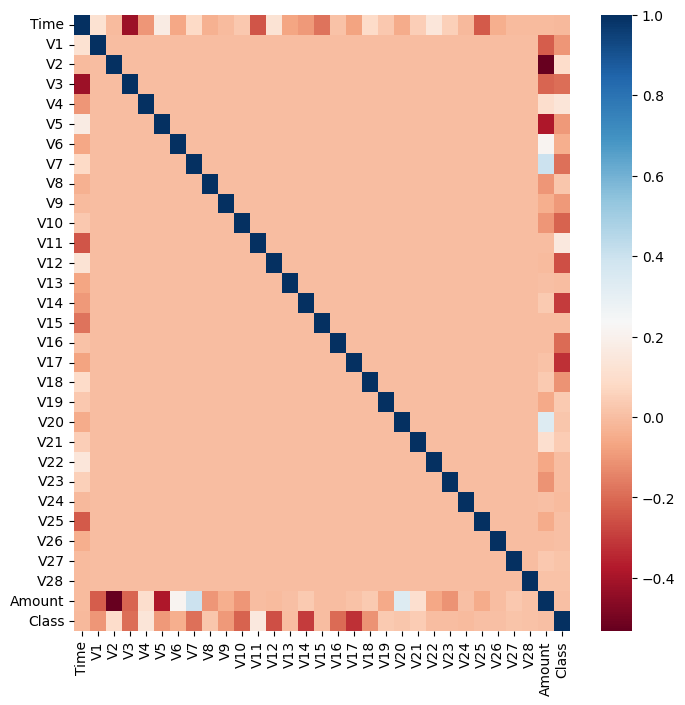

In [12]:
plt.figure(figsize=(8, 8))
corr = df_v0.corr()
sns.heatmap(corr, cmap='RdBu')
plt.show()

In [20]:
# Data Preprocessing

# Function 01
def deal_with_outliers(df=None, column=None, weight=1.5):
    # Extract values from the specified column in rows where 'Class' == 1
    fraud = df[df['Class'] == 1][column]
    # Calculate Q1 and Q3 percentiles
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # Compute IQR and determine bounds for outliers
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lower_bound = quantile_25 - iqr_weight
    upper_bound = quantile_75 + iqr_weight
    # Identify indexes of outlier values
    outlier_index = fraud[(fraud < lower_bound) | (fraud > upper_bound)].index
    return outlier_index

# Function 02
def preprocess_data(df=None):
    # Make a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    # Normalize 'Amount' using log transformation
    normalized_amount = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', normalized_amount)
    # Drop unnecessary columns
    df_copy.drop(columns=['Time', 'Amount'], inplace=True)
    # Handle outliers for the column 'V14'
    outlier_index = deal_with_outliers(df_copy, column="V14")
    df_copy.drop(index=outlier_index, inplace=True)
    return df_copy

# Function 03
def split_data(df=None):
    # Preprocess data and split into features and target sets
    df_copy = preprocess_data(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy["Class"]
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

# Function 04
def evaluate_data(y_test, predictions=None, prediction_probabilities=None):
    # Calculate and display evaluation metrics
    confusion = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, prediction_probabilities)
    print('Confusion Matrix:')
    print(confusion)
    print()
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

# Function 05
def train_model(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    # Fit model, make predictions, and evaluate results
    model.fit(ftr_train, tgt_train)
    predictions = model.predict(ftr_test)
    prediction_probabilities = model.predict_proba(ftr_test)[:, 1]
    evaluate_data(tgt_test, predictions, prediction_probabilities)

In [21]:
X_train, X_test, y_train, y_test = split_data(df_v0)

In [22]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, verbosity=-1, boost_from_average=False)
# I higly recommend to use "boost_from_average=False" when a dataset is extremely imbalanced.

In [23]:
train_model(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

Confusion Matrix:
[[85290     5]
 [   25   121]]

Accuracy: 0.9996, Precision: 0.9603, Recall: 0.8288, F1: 0.8897, AUC: 0.9780


In [24]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("Before SMOTE: ", X_train.shape, y_train.shape)
print("After SMOTE: ", X_train_over.shape, y_train_over.shape)
print("After SMOTE Label Distribution: ", pd.Series(y_train_over).value_counts())

Before SMOTE:  (199362, 29) (199362,)
After SMOTE:  (398040, 29) (398040,)
After SMOTE Label Distribution:  Class
0    199020
1    199020
Name: count, dtype: int64


In [25]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, verbosity=-1, boost_from_average=False)
train_model(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

Confusion Matrix:
[[85283    12]
 [   22   124]]

Accuracy: 0.9996, Precision: 0.9118, Recall: 0.8493, F1: 0.8794, AUC: 0.9814
